In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import *
from scipy.stats import mannwhitneyu
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import ScalarFormatter
from statannotations.Annotator import Annotator
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = 'Arial'

cmap = plt.get_cmap('coolwarm', 19)
colors = cmap(np.linspace(0.05, 0.95, 19))

## Simulated dataset

The maturation probabilities for *T. japonicus* first-time spawners at each spawning age are generated using the following equation:

$$p=\frac{1}{1+e^{-\eta[W_n-\frac{1}{k}(W_{min}+W_{max})]}}$$

Age_list: [1 2 3 4]
Torch Device: cpu
[5/20] Test Acc Q : 0.722222  
[10/20] Test Acc Q : 0.777778  
[15/20] Test Acc Q : 0.805556  
[20/20] Test Acc Q : 0.777778  
Torch Device: cpu
[5/20] Test Acc Q : 0.708333  
[10/20] Test Acc Q : 0.875000  
[15/20] Test Acc Q : 0.875000  
[20/20] Test Acc Q : 0.875000  
Torch Device: cpu
[5/20] Test Acc Q : 0.687500  
[10/20] Test Acc Q : 0.875000  
[15/20] Test Acc Q : 0.875000  
[20/20] Test Acc Q : 1.000000  
Torch Device: cpu
[5/20] Test Acc Q : 0.000000  
[10/20] Test Acc Q : 1.000000  
[15/20] Test Acc Q : 1.000000  
[20/20] Test Acc Q : 1.000000  
Age_list: [1 2 3 4]
Torch Device: cpu
[5/20] Test Acc Q : 0.763889  
[10/20] Test Acc Q : 0.763889  
[15/20] Test Acc Q : 0.777778  
[20/20] Test Acc Q : 0.777778  
Torch Device: cpu
[5/20] Test Acc Q : 0.833333  
[10/20] Test Acc Q : 0.854167  
[15/20] Test Acc Q : 0.854167  
[20/20] Test Acc Q : 0.854167  
Torch Device: cpu
[5/20] Test Acc Q : 0.906250  
[10/20] Test Acc Q : 0.937500  
[15/20] T

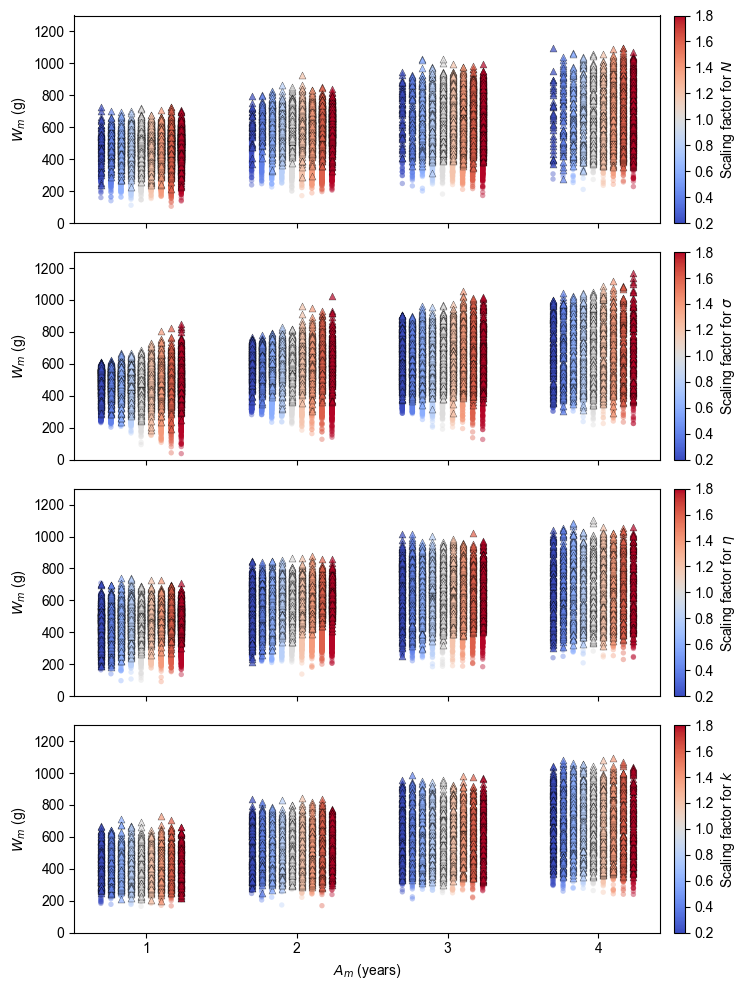

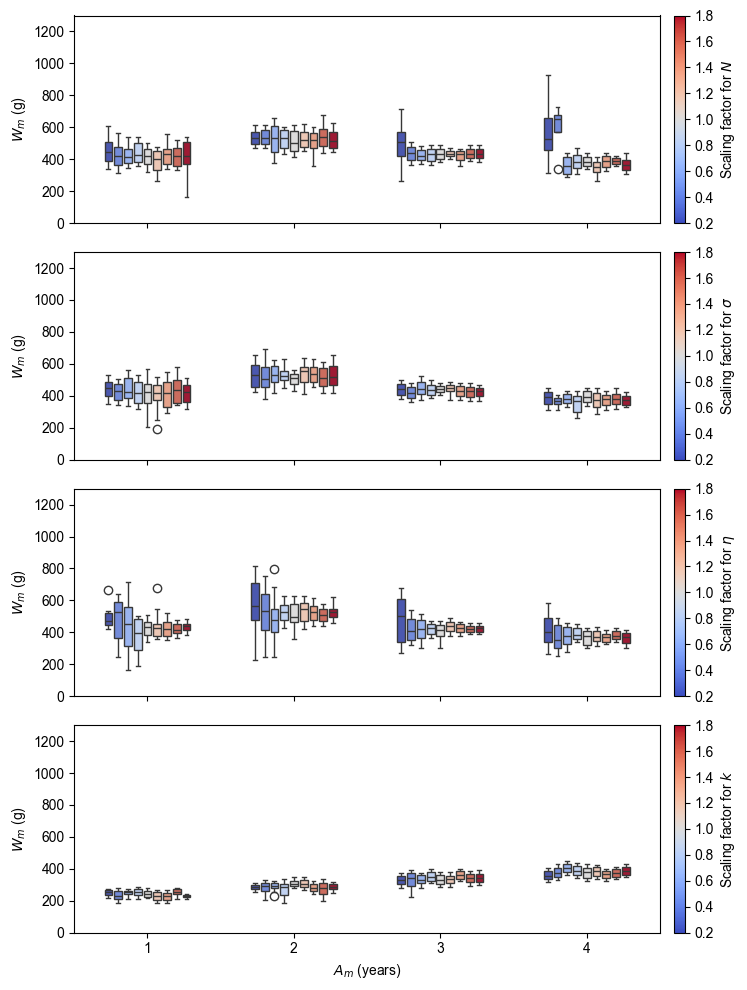

In [2]:
np.random.seed(42)

# Base parameters for simulation
age_range = [1, 2, 3, 4]  # Am
base_num_samples = [900, 600, 400, 200]  # N
base_noise_std = 50  # sigma
base_Eta = [0.02, 0.02, 0.04, 0.04]  # eta
base_K = [2, 2, 2.8, 3.5]  # k
weight_ranges = {1: (250, 600), 2: (300, 750), 3: (300, 900), 4: (320, 1000)}  # Wmin and Wmax
scaling_factors = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]  # Scaling factors to test parameter sensitivity
# scaling_factors = [2]

# Color settings for visualization
cmap = plt.get_cmap('coolwarm')
norm = Normalize(vmin=min(scaling_factors), vmax=max(scaling_factors))

# Parameters to analyze for sensitivity
parameters = [
    {'name': 'Sample Size', 'symbol': r'$N$', 'base': base_num_samples, 'is_age_specific': True},
    {'name': 'Noise Std', 'symbol': r'$\sigma$', 'base': base_noise_std, 'is_age_specific': False},
    {'name': 'Eta', 'symbol': r'$\eta$', 'base': base_Eta, 'is_age_specific': True},
    {'name': 'k', 'symbol': r'$k$', 'base': base_K, 'is_age_specific': True}
]

# Create figure objects
fig1, axes1 = plt.subplots(4, 1, figsize=(8, 10), sharex=True)  # Scatter plots showing parameter sensitivity (generating data) 
fig2, axes2 = plt.subplots(4, 1, figsize=(8, 10), sharex=True)  # Boxplots showing parameter sensitivity (QMRNs)

# Loop through each parameters
for param_idx, param in enumerate(parameters):
    ax_scatter = axes1[param_idx]
    ax_box = axes2[param_idx]
    all_qmrn_values = []

    # Loop through each scaling factor
    for scale in scaling_factors:
        # 1. DATA GENERATION ========================================
        data = []
        for age_idx, age in enumerate(age_range):
            # Calculate parameter value based on scaling factor
            if param['is_age_specific']:
                if isinstance(param['base'], list):
                    current_param = param['base'][age_idx] * scale
                else:
                    current_param = param['base'] * scale
            else:
                current_param = param['base'] * scale
            
            # Parameter assignment based on the current test parameter
            if param['name'] == 'Sample Size':
                num_samples = int(current_param)
                noise_std = base_noise_std
                eta = base_Eta[age_idx]
                k = base_K[age_idx]
            elif param['name'] == 'Noise Std':
                num_samples = base_num_samples[age_idx]
                noise_std = current_param
                eta = base_Eta[age_idx]
                k = base_K[age_idx]
            elif param['name'] == 'Eta':
                num_samples = base_num_samples[age_idx]
                noise_std = base_noise_std
                eta = current_param
                k = base_K[age_idx]
            elif param['name'] == 'K':
                num_samples = base_num_samples[age_idx]
                noise_std = base_noise_std
                eta = base_Eta[age_idx]
                k = current_param
            
            # Generate simulated data
            weight_min, weight_max = weight_ranges[age]
            weight_ = np.random.uniform(weight_min, weight_max, num_samples)
            noise = np.random.normal(0, noise_std, num_samples)
            weight = weight_ + noise

            prob = 1 / (1 + np.exp(-eta * (weight - (weight_min + weight_max) / k)))  #  maturity probability
            status = np.random.binomial(1, prob)  # Maturity status (0/1)

            # Add slight x-offset to prevent overplotting
            x_offset = 0.3 * (scaling_factors.index(scale) - len(scaling_factors)/2) / (len(scaling_factors)/2)
            for w, s in zip(weight, status):
                data.append([age, age + x_offset, w, s, scale])

        df = pd.DataFrame(data, columns=['newage', 'age_loc', 'total_w', 'mat', 'scale'])
        
        # 2. SCATTER PLOT VISUALIZATION =============================
        color = cmap(norm(scale))
        immature = df[df['mat'] == 0]
        mature = df[df['mat'] == 1]
        
        ax_scatter.scatter(immature['age_loc'], immature['total_w'],
                         color=color, alpha=0.4, s=15, edgecolor='none')
        ax_scatter.scatter(mature['age_loc'], mature['total_w'],
                         color=color, alpha=0.7, s=25, marker='^', edgecolor='k', linewidth=0.3)

        # 3. QMRNs CALCULATION ========================================
        age_list = np.sort(df.newage.unique())
        print('Age_list:', age_list)
        intersections_list = []
        
        for age in age_list:
            df_age = df[df.newage==age]
            
            try:
                temp_file = f"./Data/Sens_data/temp_simulated_Param-{param['name']}_Am-{age}_scale-{scale}.csv"
                df_age.to_csv(temp_file, index=False)

                # Deep BQR
                attribute_array, outputs = BQR(temp_file,
                                             batch_is=64,
                                             x_cols=[2],
                                             y_col=3,
                                             attribute_index=0,
                                             attribute_name="newage",
                                             latent_name="Maturity",
                                             total_epochs=20,
                                             ndim=1)
                
                 # Interpolate quantiles
                available_tau = np.linspace(0.1, 0.9, 9)
                new_tau = np.linspace(0.05, 0.95, 19)
                interpolated = [smoothed_quantile(i, available_tau, outputs) for i in new_tau]
                
                # Calculate intersections (QMRNs)
                intersections = [calculate_intersections(attribute_array, i) for i in interpolated[::-1]]
                intersections_list.append(intersections)
                
            except Exception as e:
                print(f"Skipping age {age} at scale {scale}: {str(e)}")
                intersections_list.append([np.nan] * 19)
        
        # Store QMRNs for boxplot
        qmrn_matrix = np.array(intersections_list)
        for age_idx in range(len(age_range)):
            for q_value in qmrn_matrix[age_idx]:
                all_qmrn_values.append({
                    'Age': age_range[age_idx],
                    'Value': q_value,
                    'Scale': scale})
    
    # 4. BOXPLOT VISUALIZATION =====================================
    qmrn_df = pd.DataFrame(all_qmrn_values)
    box_plot = sns.boxplot(x='Age', y='Value', hue='Scale', data=qmrn_df,
               palette=[cmap(norm(s)) for s in scaling_factors],
               ax=ax_box, width=0.6, gap=.2)
    box_plot.legend_.remove()   # Remove default legend
    
    # 5. PLOT STYLING =============================================
    for ax_idx, ax in enumerate([ax_scatter, ax_box]):
        ax.set_ylim(0, 1300)
        # ax.grid(True, linestyle='--', alpha=0.3)
        # ax.set_ylabel(r'$W_{m}$ (g)' if ax == ax_scatter else r'$W_{m}$ (g)', fontsize=10)
        ax.set_ylabel(r'$W_{m}$ (g)', fontsize=10)
        
        # Only show x-label for bottom subplot
        if param_idx == 3:
            ax.set_xlabel(r'$A_{m}$ (years)', fontsize=10)
            if ax==ax_scatter:
                ax.set_xticks(age_range)
            else:
                ax.set_xticks(np.array(age_range)-1)
        else:
            ax.set_xlabel('')

        # Add colorbar showing scaling factors
        sm = ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])
        if ax == ax_scatter:
            cbar = fig1.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
            cbar.set_label(f'Scaling factor for {param["symbol"]}', fontsize=10)
            cbar.set_ticks(scaling_factors)
            cbar.set_ticklabels([f'{s:.1f}' for s in scaling_factors])
        else:
            cbar = fig2.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
            cbar.set_label(f'Scaling factor for {param["symbol"]}', fontsize=10)
            cbar.set_ticks(scaling_factors)
            cbar.set_ticklabels([f'{s:.1f}' for s in scaling_factors])

# Save figures
fig1.tight_layout()
fig2.tight_layout()
fig1.savefig('./Figs/Figure_S5.pdf')
fig1.savefig('./Figs/Figure_S5.png', dpi=600, bbox_inches='tight')
fig1.savefig('./Figs/Figure_S6.pdf')
fig2.savefig('./Figs/Figure_S6.png', dpi=600, bbox_inches='tight')